In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob
from collections import OrderedDict
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

try:
    from importlib import reload # Python 3
except ImportError:
    pass

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import trainimagesource, trainutils, pytorchutils, pytorchnet

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

0.4.0


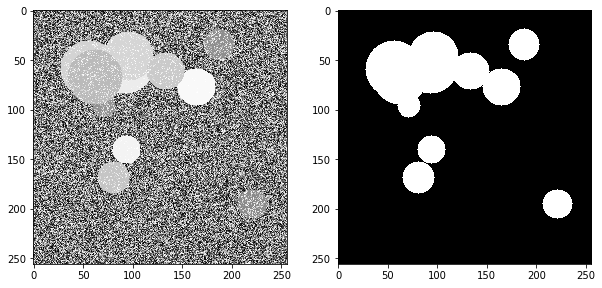

In [2]:
imwidth = 256
imheight = 256
numimgs = 500

def createTestImage(width,height,numObjs=12,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height))
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5
    
    norm=np.random.uniform(0,1.0,size=image.shape)
    
    return np.maximum(image,norm).astype(float),(image>0).astype(float)

def plotPair(im1,im2):
    '''Convenience function for plotting two images side-by-side.'''
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    
im,mask=createTestImage(imwidth,imheight)
plotPair(im,mask)

(500, 256, 256, 1) (500, 256, 256)
float32 (1, 1, 256, 256) float32 (1, 1, 256, 256)


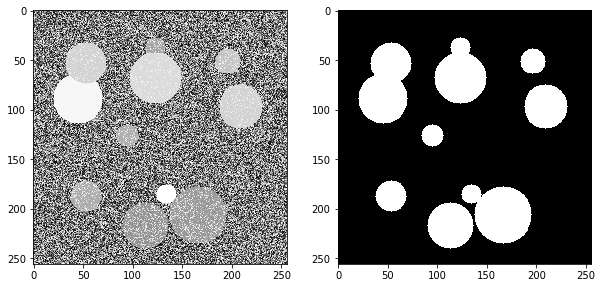

In [3]:
def convertAug(images,out):
    '''Convert `images' and `out' to CH[W] format, assuming `images' is HWC and `out' is H[W].'''
    return images.transpose([2,0,1]).astype(np.float32), out[np.newaxis,...].astype(np.float32)

dataset=[createTestImage(imwidth,imheight) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
maskin=np.concatenate([(d[1],) for d in dataset])

print(imgin.shape,maskin.shape)
src=trainimagesource.TrainImageSource(imgin,maskin,[convertAug])

im,mask=src.getBatch(1)
print(im.dtype,im.shape,mask.dtype,mask.shape)
plotPair(im[0,0],mask[0,0])

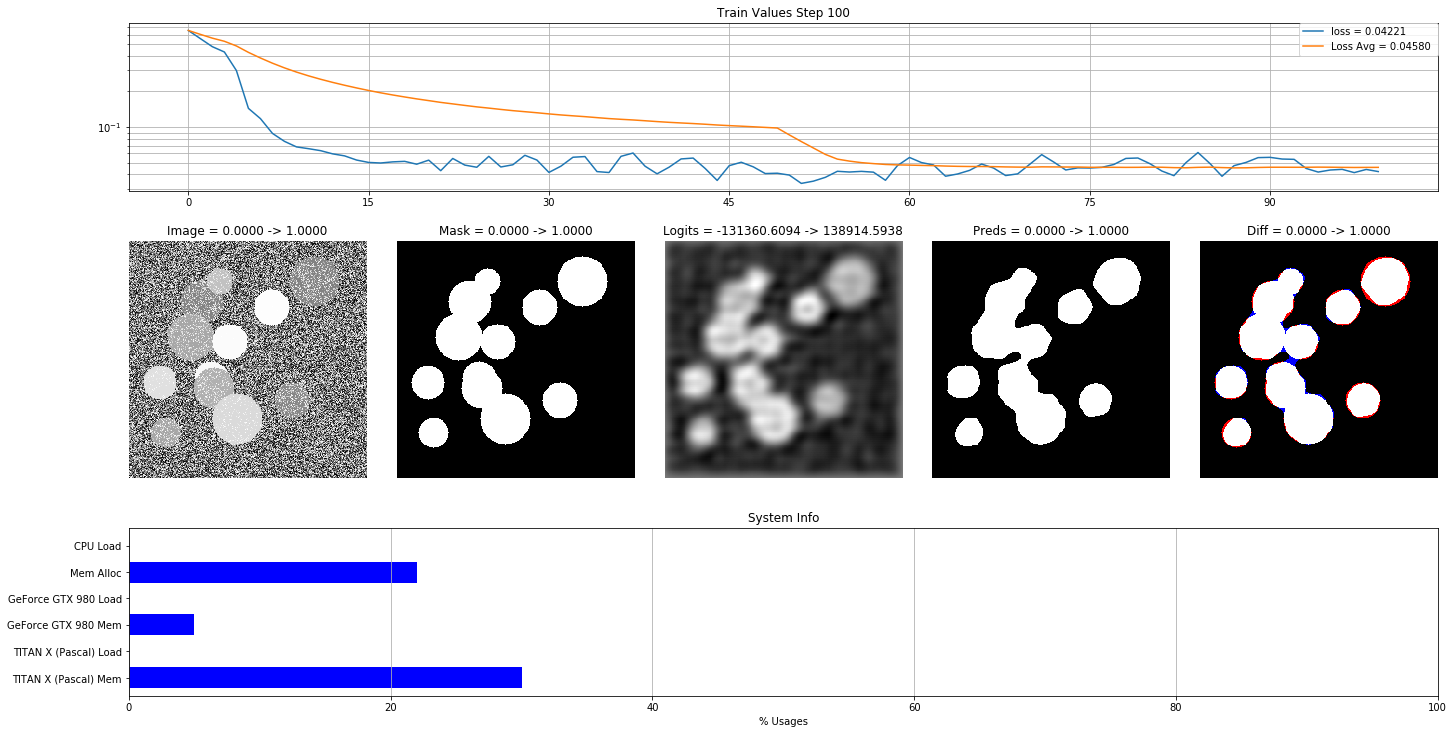

In [6]:
class UnetMgrNB(pytorchutils.BinarySegmentMgr):
    lossavgs=[]
    steplosses=[]
    lossavglen=50
    fig=None
        
    def updateStep(self,step,steploss):
        self.steplosses.append(steploss)
        self.lossavgs.append(np.average(self.steplosses[-self.lossavglen:]))
        self.log('Loss Average:',self.lossavgs[-1])
        
        if step<10 or step%5==0:
            images,masks=self.traininputs
            logits,preds=self.netoutputs

            mask=masks[0,0].cpu().data.numpy()
            preds=preds[0].cpu().data.numpy()

            imgmap=OrderedDict([
                ('Image',images[0,0].cpu().data.numpy()),
                ('Mask',mask),
                ('Logits',logits[0,0].cpu().data.numpy()),
                ('Preds',preds),
                ('Diff',np.stack([mask,mask*preds,preds],axis=2).astype(np.float32)),
            ])

            graphs={'loss':self.steplosses,'Loss Avg':self.lossavgs}
        
            self.fig,ax=trainutils.plotGraphImages('Train Values Step %i'%(step,),graphs,imgmap,fig=self.fig)
            clear_output(wait=True)
            display(plt.gcf())
    

learningRate=1e-4
trainSteps=100
batchSize=20
filters=(16, 32, 64, 128, 256)
strides=( 1,  2,  2,   2,   2)
resunits=2
kernelsize=3
        

net=pytorchnet.Unet2D(1,1,filters,strides,kernelsize,resunits)
    
mgr=UnetMgrNB(net)
mgr.train(src.getAsyncFunc(batchSize),trainSteps)

clear_output(wait=True)